Set everything up and load data.

In [1]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

In [2]:
data = pd.read_csv("data.csv", sep=";", parse_dates=["Time"], index_col="Time")
#data['Time'] = pd.to_datetime(data['Time'], format='ISO8601', utc=True)

Very simple exploration:

In [3]:
print(data.shape)
data.head()

(1441, 6)


,Consumption,Grid consumption,Grid backflow,PV generation,Battery charging,Battery discharging
Time,,,,,,
2022-03-05 08:30:00+01:00,64271.779712,59611.639881,0.0,1155.158681,0.0,3461.813704
2022-03-05 09:00:00+01:00,73479.560484,68433.723571,0.0,1594.969056,0.0,4079.943209
2022-03-05 09:30:00+01:00,83463.478524,72519.254048,0.0,2015.292333,0.0,9322.759101
2022-03-05 10:00:00+01:00,77097.835603,71244.783571,0.0,2144.178222,0.0,4177.316192
2022-03-05 10:30:00+01:00,80078.206568,71724.207800,0.0,4037.172414,0.0,4617.098633


In [4]:
missing_values = data.isnull().sum()
inf_values = data.isin([float('inf'), float('-inf')]).sum()
print(missing_values)
print(inf_values)

Consumption            4
Grid consumption       4
Grid backflow          4
PV generation          4
Battery charging       4
Battery discharging    4
dtype: int64
Consumption            0
Grid consumption       0
Grid backflow          0
PV generation          0
Battery charging       0
Battery discharging    0
dtype: int64


In [5]:
data.interpolate(inplace=True)
missing_values = data.isnull().sum()
print(missing_values)

Consumption            0
Grid consumption       0
Grid backflow          0
PV generation          0
Battery charging       0
Battery discharging    0
dtype: int64


In [6]:
data.describe()

,Consumption,Grid consumption,Grid backflow,PV generation,Battery charging,Battery discharging
count,1441.000000,1441.000000,1441.0,1441.000000,1441.000000,1441.000000
mean,48402.194848,43395.528665,0.0,4006.738011,1205.206778,1053.758608
std,23614.037937,17371.196102,0.0,7269.732044,5582.340063,3126.105165
min,19169.757024,17825.026587,0.0,0.000000,0.000000,0.000000
25%,28570.989643,28510.857778,0.0,0.000000,0.000000,0.000000
50%,31971.476724,31573.590079,0.0,0.000000,0.000000,0.000000
75%,71694.121190,60255.211151,0.0,4763.451609,0.000000,240.163588
max,110821.688532,79307.399918,0.0,29933.009444,33812.363856,34008.119802


Plot each quantity raw series individually:

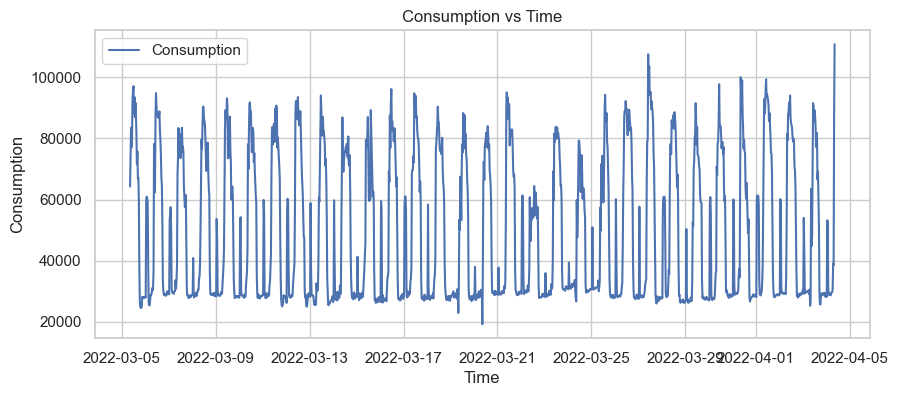

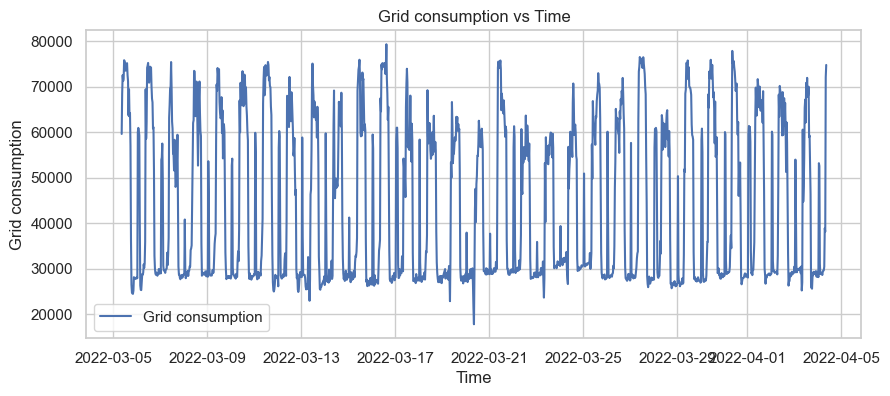

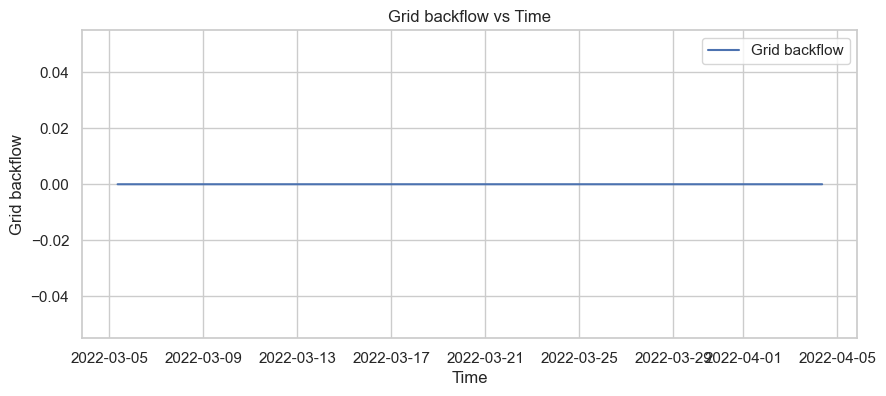

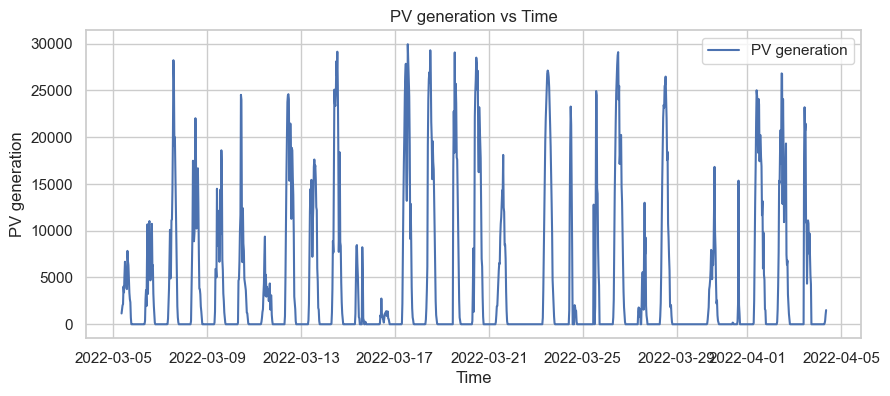

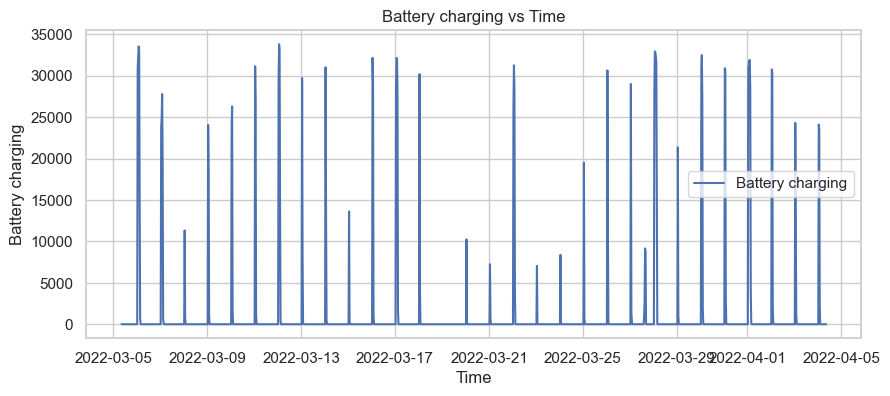

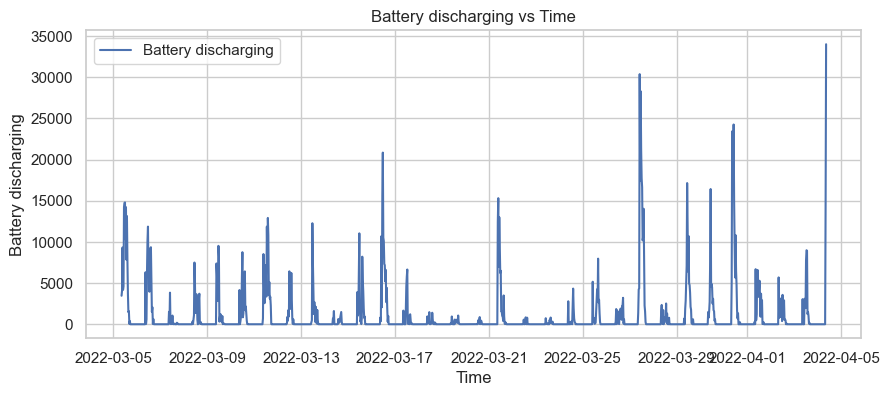

In [7]:
all_quantities = ['Consumption', 'Grid consumption', 'Grid backflow', 'PV generation', 'Battery charging', 'Battery discharging']

for quantity in all_quantities:
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data[quantity], label=quantity)
    plt.xlabel('Time')
    plt.ylabel(quantity)
    plt.title(f'{quantity} vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

Check some simple pair correlations:

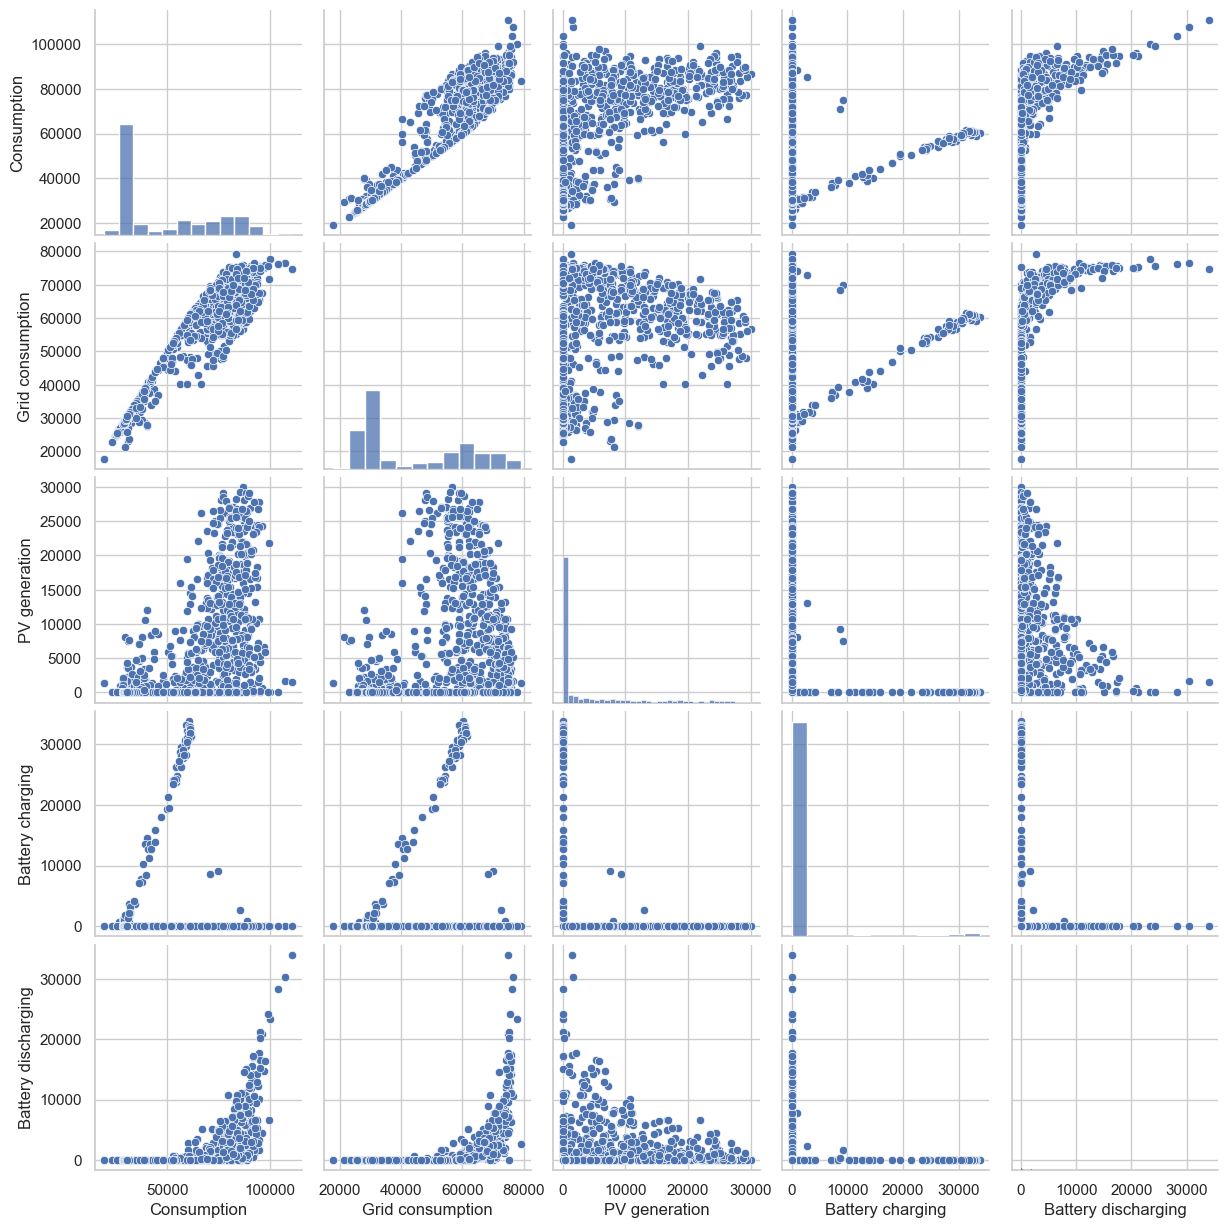

In [8]:
interesting_quantities = ['Consumption', 'Grid consumption', 'PV generation', 'Battery charging', 'Battery discharging']
sns.pairplot(data=data[interesting_quantities])

<Axes: >

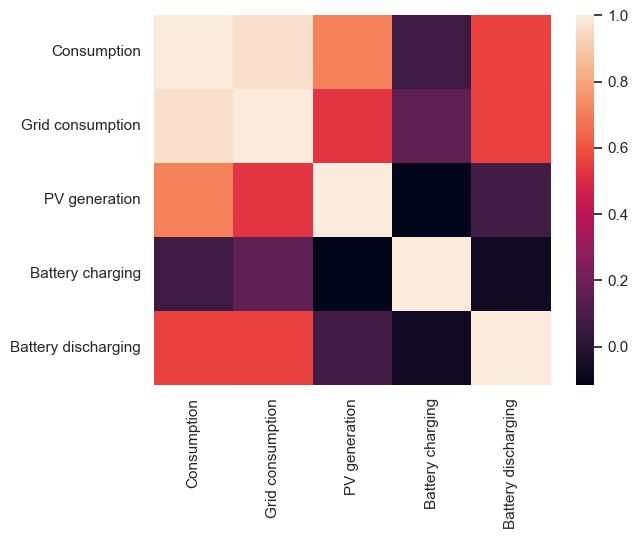

In [9]:
corr = data[interesting_quantities].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)


Check stationarity with Dickey-Fuller test:

In [ ]:
from statsmodels.tsa.stattools import adfuller

for quantity in interesting_quantities:
    result = adfuller(data[quantity], autolag='AIC')
    p_value = result[1]
    result = 'stationary' if p_value < 0.05 else 'NOT stationary'
    print(f'{quantity} is {result} (p-val= {p_value})')


Consumption is stationary (p-val = 4.713951380354999e-26)
Grid consumption is stationary (p-val = 2.849010810379848e-23)
PV generation is stationary (p-val = 8.833241719804191e-19)
Battery charging is stationary (p-val = 3.94494168345259e-29)
Battery discharging is stationary (p-val = 3.3920846069902316e-17)


Check autocorrelation (both full and partial):

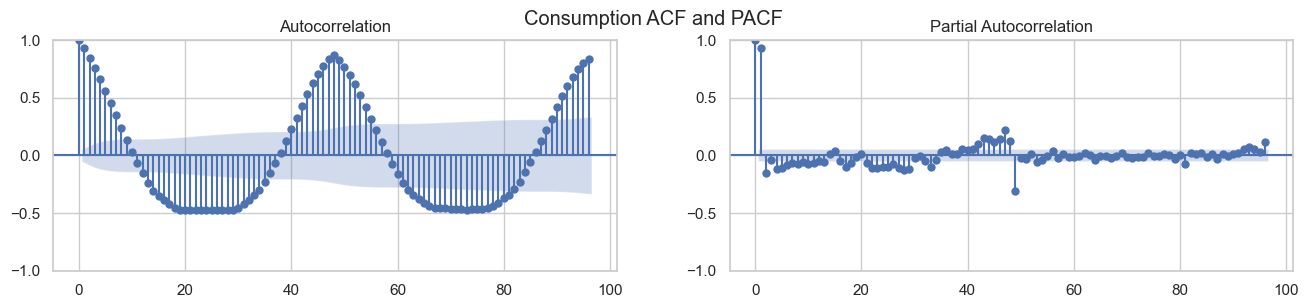

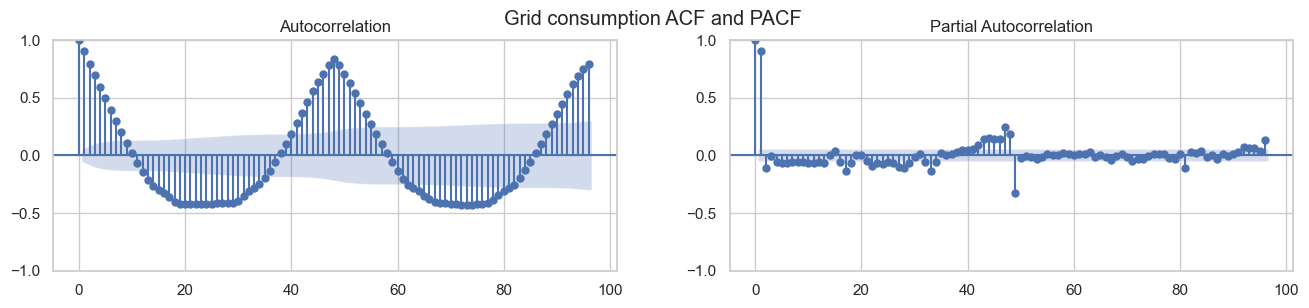

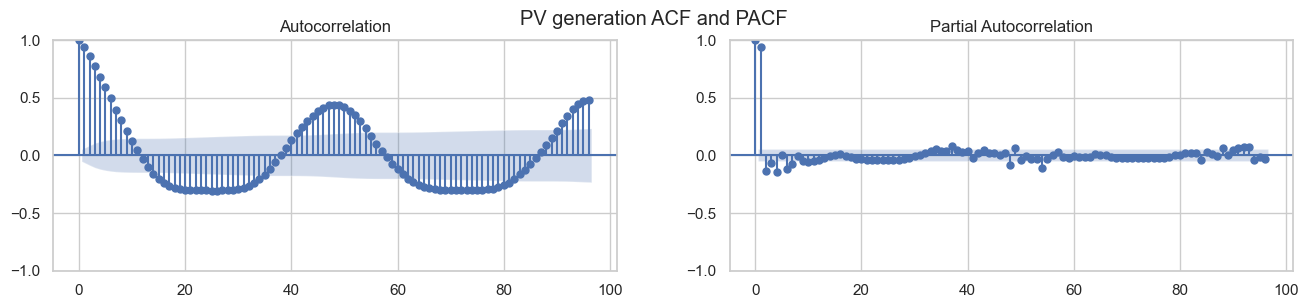

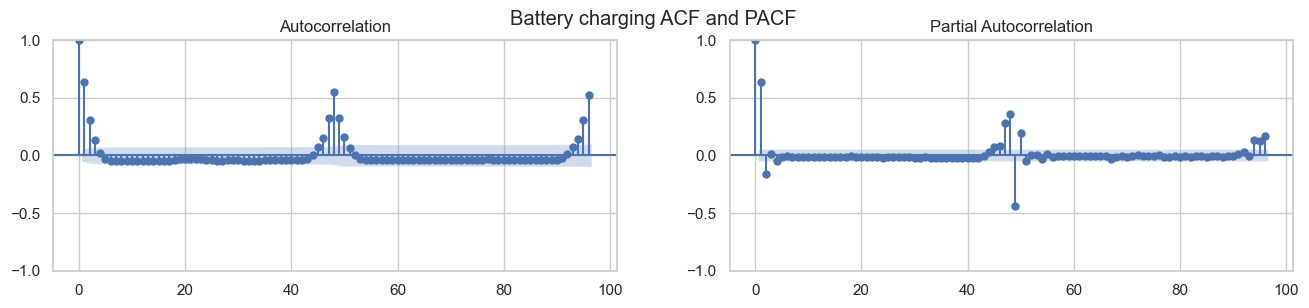

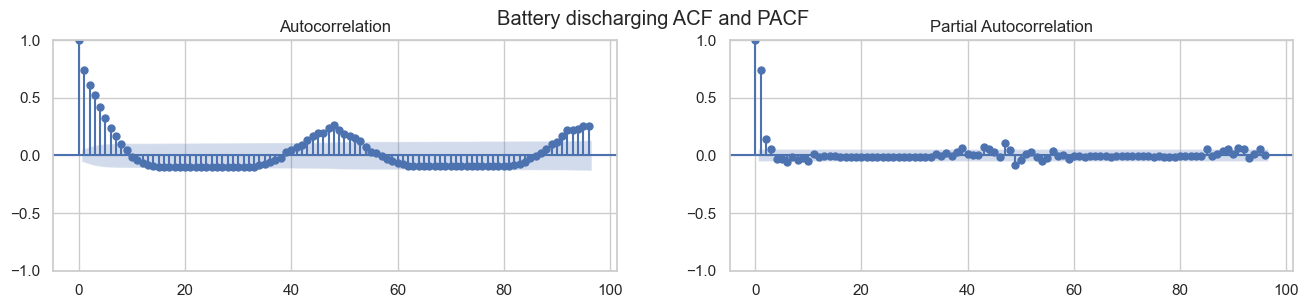

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for quantity in interesting_quantities:
    fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
    fig.suptitle(f'{quantity} ACF and PACF')
    _ = plot_acf(data[quantity].tolist(), lags=96, ax=axes[0])
    _ = plot_pacf(data[quantity].tolist(), lags=96, ax=axes[1])
